In [1]:
from sklearn.cluster import KMeans
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv
/kaggle/input/metropt-3-dataset/Data Description_Metro.pdf


In [2]:
#%%timeit
# Reading in first 100k rows of MetroPT3 Air Compressor data
metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', engine='pyarrow')
metro_df_large.head()

,,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [3]:
metro_df_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516948 entries, 0 to 1516947
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0                    1516948 non-null  int64         
 1   timestamp        1516948 non-null  datetime64[ns]
 2   TP2              1516948 non-null  float64       
 3   TP3              1516948 non-null  float64       
 4   H1               1516948 non-null  float64       
 5   DV_pressure      1516948 non-null  float64       
 6   Reservoirs       1516948 non-null  float64       
 7   Oil_temperature  1516948 non-null  float64       
 8   Motor_current    1516948 non-null  float64       
 9   COMP             1516948 non-null  float64       
 10  DV_eletric       1516948 non-null  float64       
 11  Towers           1516948 non-null  float64       
 12  MPG              1516948 non-null  float64       
 13  LPS              1516948 non-null  float64       
 14  Pr

In [4]:
metro_df_large.describe()

,,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06,1.516948e+06
mean,7.584735e+06,1.367826e+00,8.984611e+00,7.568155e+00,5.595619e-02,8.985233e+00,6.264418e+01,2.050171e+00,8.369568e-01,1.606106e-01,9.198483e-01,8.326640e-01,3.420025e-03,9.914368e-01,9.041556e-01,9.371066e-01
std,4.379053e+06,3.250930e+00,6.390951e-01,3.333200e+00,3.824015e-01,6.383070e-01,6.516261e+00,2.302053e+00,3.694052e-01,3.671716e-01,2.715280e-01,3.732757e-01,5.838091e-02,9.214078e-02,2.943779e-01,2.427712e-01
min,0.000000e+00,-3.200000e-02,7.300000e-01,-3.600000e-02,-3.200000e-02,7.120000e-01,1.540000e+01,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.792368e+06,-1.400000e-02,8.492000e+00,8.254000e+00,-2.200000e-02,8.494000e+00,5.777500e+01,4.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,7.584735e+06,-1.200000e-02,8.960000e+00,8.784000e+00,-2.000000e-02,8.960000e+00,6.270000e+01,4.500000e-02,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,1.137710e+07,-1.000000e-02,9.492000e+00,9.374000e+00,-1.800000e-02,9.492000e+00,6.725000e+01,3.807500e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,1.516947e+07,1.067600e+01,1.030200e+01,1.028800e+01,9.844000e+00,1.030000e+01,8.905000e+01,9.295000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [5]:
print(metro_df_large.Caudal_impulses.value_counts())

1.0    1421542
0.0      95406
Name: Caudal_impulses, dtype: int64


As the caudal impulses feature only contains the value 1 for all records I will not use it going forward.

Failure Information:

The dataset is unlabeled, but the failure reports provided by the company are available in the following table. This allows for evaluating the effectiveness of anomaly detection, failure prediction, and RUL estimation algorithms.

  Nr.     Start Time	          End Time	                 Failure	      Severity	         Report
* #1 	4/18/2020 0:00	   4/18/2020 23:59       Air leak	    High stress	
* #1 	5/29/2020 23:30     5/30/2020 6:00	    Air Leak	    High stress	Maintenance on 30Apr at 12:00
* #3 	6/5/2020 10:00	   6/7/2020 14:30	        Air Leak	    High stress	Maintenance on 8Jun at 16:00
* #4 	7/15/2020 14:30     7/15/2020 19:00      Air Leak	    High stress	Maintenance on 16Jul at 00:00

In [6]:
metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)
metro_df_clustering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516948 entries, 0 to 1516947
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   TP2              1516948 non-null  float64
 1   TP3              1516948 non-null  float64
 2   H1               1516948 non-null  float64
 3   DV_pressure      1516948 non-null  float64
 4   Reservoirs       1516948 non-null  float64
 5   Oil_temperature  1516948 non-null  float64
 6   Motor_current    1516948 non-null  float64
 7   COMP             1516948 non-null  float64
 8   DV_eletric       1516948 non-null  float64
 9   Towers           1516948 non-null  float64
 10  MPG              1516948 non-null  float64
 11  LPS              1516948 non-null  float64
 12  Pressure_switch  1516948 non-null  float64
 13  Oil_level        1516948 non-null  float64
 14  Caudal_impulses  1516948 non-null  float64
dtypes: float64(15)
memory usage: 173.6 MB


In [7]:
# Set up KMeans
kmeans = KMeans(n_clusters=3)

# Fit the model to the data
kmeans.fit(metro_df_clustering)

# Predict the clusters
metro_df_large['cluster'] = kmeans.predict(metro_df_clustering)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
metro_df_large.head()

,,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,cluster
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2


In [9]:
metro_df_large.cluster.value_counts()

0    650510
2    644956
1    221482
Name: cluster, dtype: int64

In [10]:
cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()
cluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()
cluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()

cluster_0_df.head()


,,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,cluster
4799,47990,2020-02-01 13:17:44,-0.012,9.888,9.874,-0.012,9.888,61.275,3.7500,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
5011,50110,2020-02-01 13:52:46,-0.014,9.926,9.916,-0.012,9.928,61.325,3.7975,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
5012,50120,2020-02-01 13:52:56,-0.012,9.906,9.896,-0.012,9.910,61.650,3.8375,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
5013,50130,2020-02-01 13:53:06,-0.012,9.890,9.876,-0.012,9.892,61.775,3.7900,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0
5014,50140,2020-02-01 13:53:16,-0.012,9.872,9.858,-0.014,9.876,61.600,3.7425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0


In [11]:
cluster_0_df.describe()

,,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,cluster
count,6.505100e+05,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.000000,650510.0
mean,9.649379e+06,-0.005368,9.267261,9.253282,-0.013989,9.267886,66.830597,2.276791,0.992340,0.010383,0.992649,0.982521,0.000046,0.991553,0.845128,0.920103,0.0
std,3.817329e+06,0.167624,0.542499,0.558846,0.131368,0.541258,3.209411,1.829999,0.087186,0.101365,0.085423,0.131046,0.006791,0.091520,0.361783,0.271134,0.0
min,4.799000e+04,-0.032000,1.446000,-0.008000,-0.032000,1.442000,60.875000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,7.499652e+06,-0.014000,8.868000,8.854000,-0.022000,8.870000,64.275000,0.042500,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.0
50%,1.047520e+07,-0.012000,9.342000,9.330000,-0.020000,9.342000,66.550000,3.690000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.0
75%,1.274052e+07,-0.010000,9.714000,9.700000,-0.018000,9.712000,68.950000,3.777500,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.0
max,1.516923e+07,7.592000,10.302000,10.288000,6.282000,10.300000,82.575000,9.295000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [12]:
cluster_1_df.describe()

,,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,cluster
count,2.214820e+05,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.000000,221482.0
mean,8.356180e+06,8.876913,8.920109,-0.001019,0.479781,8.919129,67.552626,5.792198,0.003224,0.980491,0.525677,0.002677,0.009495,0.976075,0.909744,0.930211,1.0
std,3.713688e+06,1.356768,0.786798,0.229035,0.848533,0.785565,6.643879,0.323309,0.056687,0.138307,0.499341,0.051675,0.096979,0.152817,0.286548,0.254792,0.0
min,2.487000e+04,-0.014000,0.886000,-0.036000,-0.030000,0.866000,52.300000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,5.289112e+06,8.390000,8.404000,-0.014000,-0.020000,8.402000,62.750000,5.575000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
50%,8.937235e+06,9.042000,8.874000,-0.012000,-0.016000,8.874000,67.175000,5.845000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
75%,1.102779e+07,9.804000,9.554000,-0.008000,0.716000,9.552000,73.700000,6.037500,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
max,1.516871e+07,10.676000,10.288000,8.778000,9.844000,10.290000,89.050000,6.402500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [13]:
cluster_2_df.describe()

,,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,cluster
count,6.449560e+05,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.000000,644956.0
mean,5.237393e+06,0.174177,8.721676,8.467819,-0.019041,8.722848,56.736124,0.536563,0.966545,0.030580,0.981782,0.966539,0.004737,0.996595,0.961773,0.956625,2.0
std,3.956661e+06,1.227501,0.547812,1.565355,0.083861,0.547693,3.669805,1.378158,0.179822,0.172178,0.133740,0.179838,0.068661,0.058252,0.191745,0.203700,0.0
min,0.000000e+00,-0.032000,0.730000,-0.034000,-0.032000,0.712000,15.400000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,1.790848e+06,-0.014000,8.336000,8.310000,-0.024000,8.336000,54.600000,0.040000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
50%,4.722795e+06,-0.014000,8.646000,8.622000,-0.022000,8.648000,57.200000,0.042500,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
75%,7.200092e+06,-0.012000,9.056000,9.034000,-0.020000,9.058000,59.575000,0.042500,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.0
max,1.516947e+07,10.652000,10.248000,10.250000,7.558000,10.244000,62.550000,9.175000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0


<Axes: title={'center': 'Cluster 2'}, xlabel='Motor_current', ylabel='TP2'>

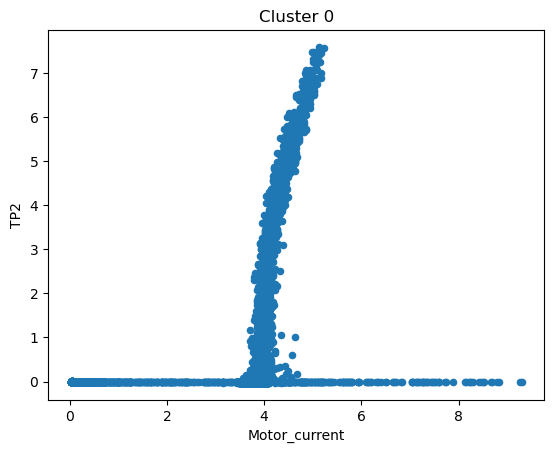

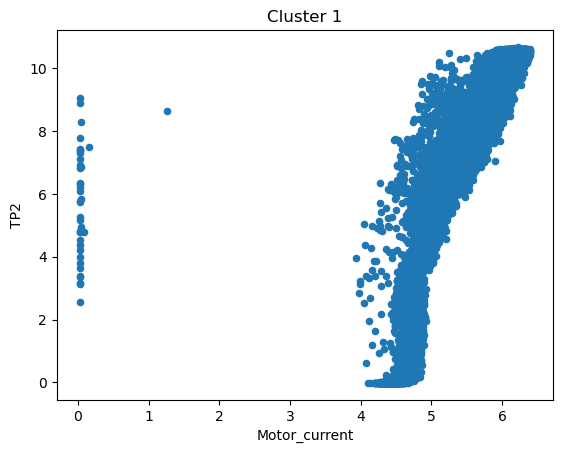

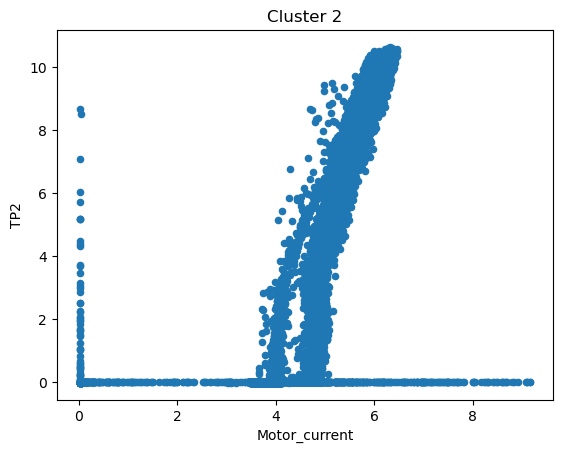

In [14]:
cluster_0_df.plot(x='Motor_current',y='TP2', kind='scatter', title='Cluster 0')
cluster_1_df.plot(x='Motor_current',y='TP2', kind='scatter', title='Cluster 1')
cluster_2_df.plot(x='Motor_current',y='TP2', kind='scatter', title='Cluster 2')

In [15]:
metro_df_large['oil_rolling'] = metro_df_large['Oil_temperature'].rolling(6).mean()
metro_df_large.head()

,,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,cluster,oil_rolling
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2,NaN
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2,NaN
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2,NaN
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2,NaN
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2,NaN


In [16]:
metro_sample = metro_df_large.sample(frac=0.2)

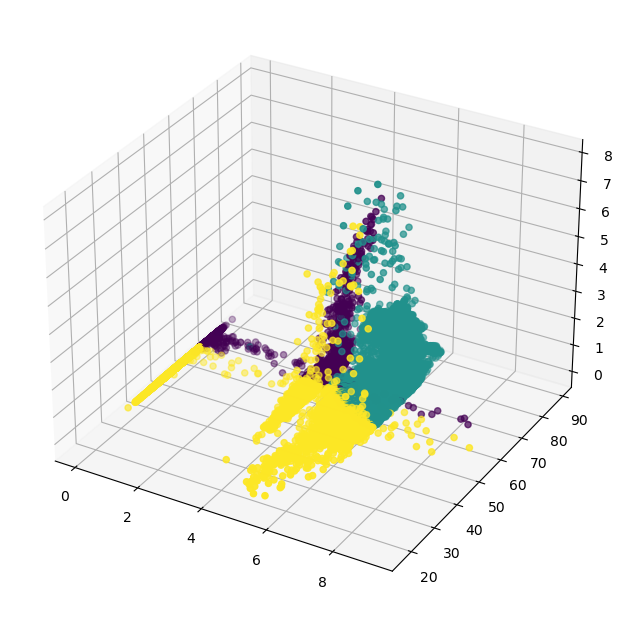

In [17]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)


ax.scatter(data=metro_sample, xs='Motor_current',ys='Oil_temperature', zs='DV_pressure', c='cluster')

In [18]:
"""fig = px.line(metro_df_large, x ='timestamp', y='oil_rolling', facet_col='cluster', facet_col_wrap=1)
fig.show()"""

"fig = px.line(metro_df_large, x ='timestamp', y='oil_rolling', facet_col='cluster', facet_col_wrap=1)\nfig.show()"

In [19]:
metro_df_large.oil_rolling.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1516948 entries, 0 to 1516947
Series name: oil_rolling
Non-Null Count    Dtype  
--------------    -----  
1516943 non-null  float64
dtypes: float64(1)
memory usage: 11.6 MB
